In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_rows', 10)  # Muestra todas las filas

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc
)
from lightgbm import LGBMClassifier


In [2]:
df = pd.read_csv("Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [3]:
# Verificar si hay valores duplicados según las características seleccionadas
# keep=False significa marcar todos los duplicados
valores_duplicados = df.duplicated(subset=["CustomerId"], keep=False)
df_duplicados_CustomerId = df[valores_duplicados].sort_values(by=["CustomerId"])

# Mostrar cualquier valor duplicado
df_duplicados_CustomerId

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
10001,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1


In [4]:
# Realice una copia de seguridad del conjunto de datos original (df) usando el nombre df_bk
df_bk = df.copy()

In [5]:
# Limpiar los datos eliminando los duplicados 
# Al usar `keep="first`, la segunda fila se considerará duplicada y se eliminará.
df_clean = df.drop_duplicates(subset=["CustomerId"], keep="first")

# Comparación antes y después de eliminar los duplicados
print(f"Número de filas antes de la limpieza: {len(df_bk)}")
print(f"Número de filas despues de la limpieza: {len(df_clean)}")
print(f"Duplicados eliminados: {len(df_bk) - len(df_clean)}")

Número de filas antes de la limpieza: 10002
Número de filas despues de la limpieza: 10000
Duplicados eliminados: 2


In [6]:
# Eliminar filas con valores faltantes de las funciones HasCrCard, Geography e IsActiveMember
df_clean.dropna(subset=["HasCrCard", "Geography", "IsActiveMember"], inplace=True)

# Sustituir el valor faltante de la característica Edad con el valor medio
df_clean["Age"].fillna(df_clean["Age"].median(), inplace=True)

C:\Users\horo\AppData\Local\Temp\ipykernel_1380\1060100815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.dropna(subset=["HasCrCard", "Geography", "IsActiveMember"], inplace=True)
C:\Users\horo\AppData\Local\Temp\ipykernel_1380\1060100815.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean["Age"].fillna(df_clean["Age"].m

In [7]:
# Transforma el Dtype de los valores dentro de HasCrCard e IsActiveMember de Float a Int
df_clean["HasCrCard"] = df_clean["HasCrCard"].astype(int)
df_clean["IsActiveMember"] = df_clean["IsActiveMember"].astype(int)


# cambiar el tipo de dato a entero para la columna Age
df_clean['Age'] = df_clean['Age'].round().astype(int)

C:\Users\horo\AppData\Local\Temp\ipykernel_1380\601477702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["HasCrCard"] = df_clean["HasCrCard"].astype(int)
C:\Users\horo\AppData\Local\Temp\ipykernel_1380\601477702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["IsActiveMember"] = df_clean["IsActiveMember"].astype(int)
C:\Users\horo\AppData\Local\Temp\ipykernel_1380\601477702.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [8]:
# Filtrar los datos atipicos
df_clean = df_clean[(df_clean["Age"] - df_clean["Tenure"]) >= 18]

In [9]:
# Eliminar funciones que ya no son necesarias de df_clean
eliminar_lista_columnas = ["RowNumber", "CustomerId", "Surname"]
df_clean.drop(columns=eliminar_lista_columnas, axis=1, inplace=True)

In [10]:
# Separación de características numéricas y categóricas
numerical_features = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]
categorical_features = ["Geography", "Gender", "HasCrCard", "IsActiveMember"]

In [11]:
pd.set_option('display.max_rows', 10)
df_clean[(df_clean['NumOfProducts'] < -0.5) | (df_clean['NumOfProducts'] > 3.5)]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
70,738,Germany,Male,58,2,133745.44,4,1,0,28373.86,1
1254,628,France,Female,46,1,46870.43,4,1,0,31272.14,1
1469,819,Germany,Female,49,1,120656.86,4,0,0,166164.30,1
1488,596,Spain,Male,30,6,121345.88,4,1,0,41921.75,1
...,...,...,...,...,...,...,...,...,...,...,...
9323,644,France,Male,50,9,76817.00,4,1,0,196371.13,1
9370,561,France,Male,43,4,0.00,4,0,0,18522.91,1
9411,689,Germany,Female,40,4,78119.59,4,1,0,119259.34,1
9540,727,Germany,Male,46,3,115248.11,4,1,0,130752.01,1


Q1 for CreditScore: 583.0
Q3 for CreditScore: 718.0
IQR for CreditScore: 135.0
Lower Bound for CreditScore: 380.5
Upper Bound for CreditScore: 920.5
(14, 11)
Q1 for Age: 32.0
Q3 for Age: 44.0
IQR for Age: 12.0
Lower Bound for Age: 14.0
Upper Bound for Age: 62.0
(359, 11)
Q1 for Tenure: 2.0
Q3 for Tenure: 7.0
IQR for Tenure: 5.0
Lower Bound for Tenure: -5.5
Upper Bound for Tenure: 14.5
(0, 11)
Q1 for Balance: 0.0
Q3 for Balance: 127624.09
IQR for Balance: 127624.09
Lower Bound for Balance: -191436.135
Upper Bound for Balance: 319060.225
(0, 11)
Q1 for NumOfProducts: 1.0
Q3 for NumOfProducts: 2.0
IQR for NumOfProducts: 1.0
Lower Bound for NumOfProducts: -0.5
Upper Bound for NumOfProducts: 3.5
(60, 11)
Q1 for EstimatedSalary: 50811.865
Q3 for EstimatedSalary: 149154.69
IQR for EstimatedSalary: 98342.82500000001
Lower Bound for EstimatedSalary: -96702.37250000003
Upper Bound for EstimatedSalary: 296668.9275
(0, 11)


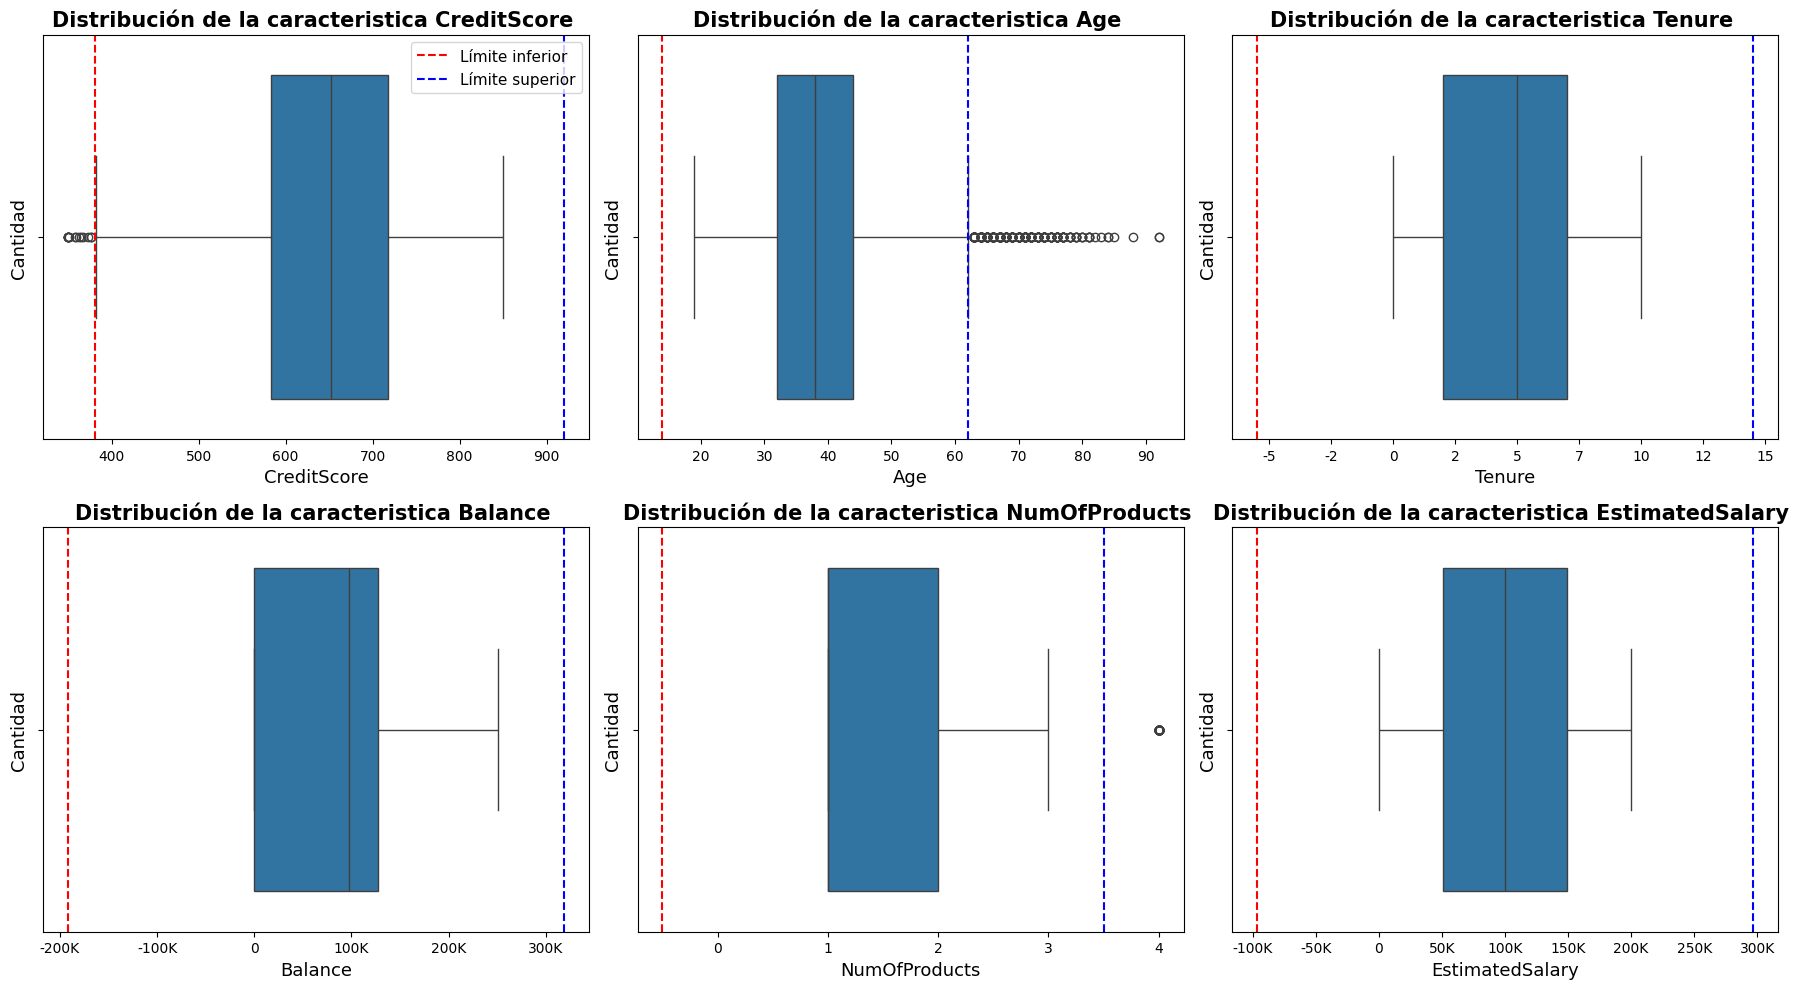

In [12]:
# Para una mejor legibilidad, voy a utilizar el formato K y M para las cifras numéricas.
# Por ejemplo: cambia 100.000 en 100k y 1.000.000 en 1M

# Función para formato numérico K y M (incluidos valores negativos)
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.0f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'

    return f'-{formatted}' if x < 0 else formatted

formatter = FuncFormatter(thousands_formatter)

# Crea y configura el tamaño de los diagramas de caja (ampliados para una mejor legibilidad)
plt.figure(figsize=(18, 10))

# Recorra cada característica para trazar su diagrama de caja
for i, col in enumerate(numerical_features):
    ax = plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df_clean, x=col, ax=ax)

    # Calcular el IQR para umbrales de valores atípicos
    Q1 = df_clean[col].quantile(0.25)
    print(f"Q1 for {col}: {Q1}")
    Q3 = df_clean[col].quantile(0.75)
    print(f"Q3 for {col}: {Q3}")
    IQR = Q3 - Q1
    print(f"IQR for {col}: {IQR}")
    lower_bound = Q1 - 1.5 * IQR
    print(f"Lower Bound for {col}: {lower_bound}")
    upper_bound = Q3 + 1.5 * IQR
    print(f"Upper Bound for {col}: {upper_bound}")

    # Agregue líneas verticales para los umbrales de valores atípicos en la visualización del diagrama de caja
    ax.axvline(lower_bound, color="red", linestyle="--", label="Límite inferior")
    ax.axvline(upper_bound, color="blue", linestyle="--", label="Límite superior")   
    
    ax.set_title(f"Distribución de la caracteristica {col} ", fontsize=15, fontweight="bold")
    ax.set_xlabel(col, fontsize=13)
    ax.set_ylabel("Cantidad", fontsize=13)  
    ax.xaxis.set_major_formatter(formatter)  # Para hacer que los formatos de números sean más concisos

    df_outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    print(df_outliers.shape)
    # Agregue leyenda solo al primer gráfico para evitar repeticiones
    if i == 0:
        ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

In [13]:
# Las funciones para detectar valores atípicos dentro del conjunto de datos utilizando el método IQR
def detect_outliers_iqr(dataframe, numerical_cols):
    outlier_summary = []

    for col in numerical_cols:
        # Cálculo de los límites inferior y superior del marco de datos
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1

        # Defina límites inferiores y superiores para valores atípicos utilizando el IQR (rango intercuartil)
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificar y contar los valores atípicos
        outliers = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)]
        outlier_count = outliers.shape[0]
        outlier_percentage = 100 * outlier_count / dataframe.shape[0]

        # Añadir el resultado de valores atípicos a la lista de resumen
        outlier_summary.append({
            "Característica": col,
            "Recuento de outlier": outlier_count,
            "Porcentaje de outlier (%)": round(outlier_percentage, 2)
        })

    # Convertir a tabla DataFrame para facilitar la lectura
    return pd.DataFrame(outlier_summary)

# Asignar df_customer como el marco de datos de la función detect_outliers_iqr
# Asignar características numéricas como columnas numéricas de la función detect_outliers_iqr
outlier_stats = detect_outliers_iqr(df_clean, numerical_features)

# Mostrar los resultados
print(outlier_stats)

    Característica  Recuento de outlier  Porcentaje de outlier (%)
0      CreditScore                   14                       0.14
1              Age                  359                       3.71
2           Tenure                    0                       0.00
3          Balance                    0                       0.00
4    NumOfProducts                   60                       0.62
5  EstimatedSalary                    0                       0.00


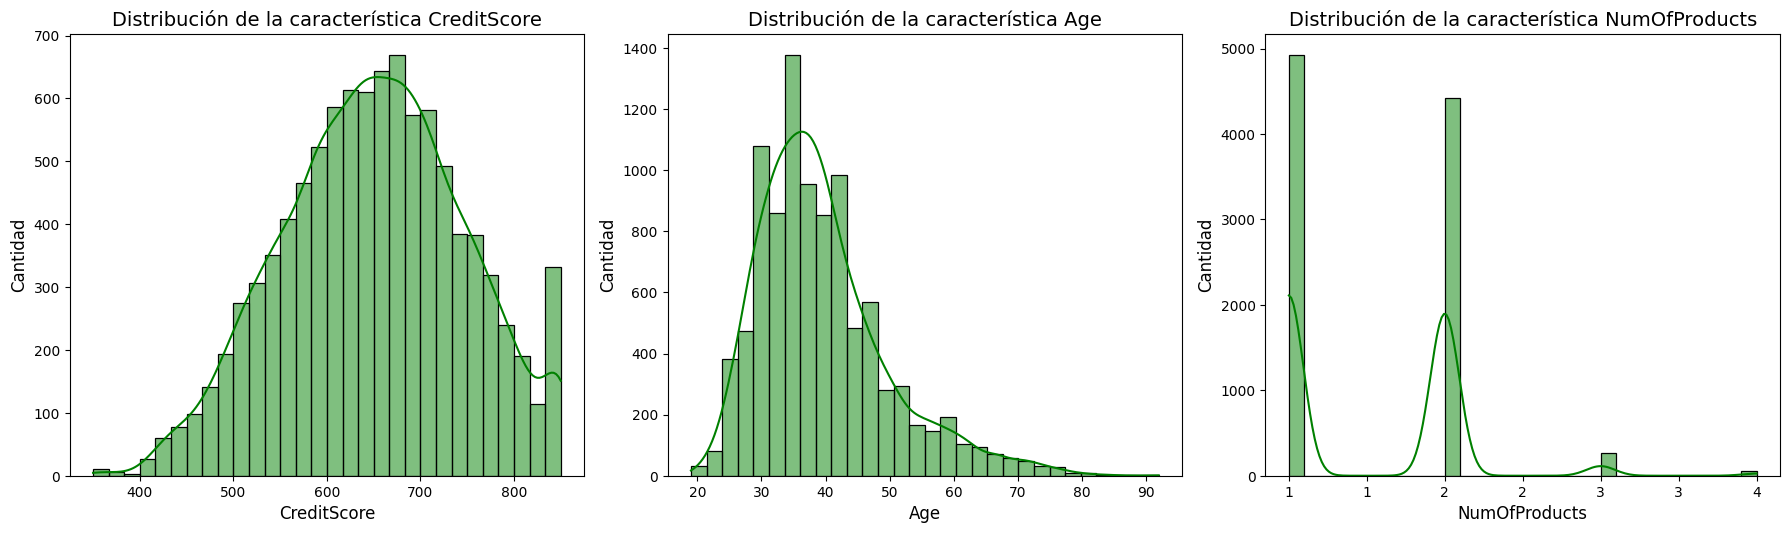

In [14]:
# Crea y configura el tamaño de los histplots (ampliados para una mejor legibilidad)
plt.figure(figsize=(18, 10))
numerical_features_2 = ["CreditScore", "Age", "NumOfProducts"]
# Recorra cada característica para trazar su histograma
for i, col in enumerate(numerical_features_2):
    ax = plt.subplot(2, 3, i + 1)
    sns.histplot(data=df_clean, x=col, kde=True, bins=30, ax=ax, color='green', edgecolor='black')
    
    ax.set_title(f'Distribución de la característica {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Cantidad', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

    # Aplicar formateador para mostrar números grandes en formato K y M
    # Por ejemplo: cambiar 100.000 en 100k y 1.000.000 en 1M
    ax.xaxis.set_major_formatter(formatter)

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()

Clientes que abandonaron:
Exited_Texto
0 = No    7662
1 = Si    2013
Name: count, dtype: int64
------------------------------


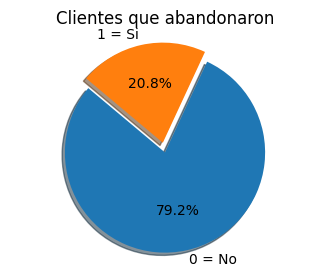

In [15]:
df_pie = df_clean.copy()
mapeo = {
    0: '0 = No',
    1: '1 = Si'
}

# Aplicar el mapeo a la columna 
df_pie['Exited_Texto'] = df_pie['Exited'].map(mapeo)

# Contar la frecuencia de cada ocupación
exited_counts = df_pie['Exited_Texto'].value_counts()

# Mostrar el conteo para verificar
print("Clientes que abandonaron:")
print(exited_counts)
print("-" * 30)

# Preparar los datos para el gráfico de pastel
labels = exited_counts.index # Nombres de las ocupaciones
sizes = exited_counts.values # Cantidad de personas por ocupación
explode = [0.05] * len(labels) # Pequeña "explosión" para cada rebanada para mejorar la visibilidad

# Crear el gráfico de pastel
plt.figure(figsize=(4, 3)) # Ajusta el tamaño de la figura para que el gráfico se vea bien
plt.pie(sizes,
        explode=explode, # Aplica la "explosión"
        labels=labels,
        autopct='%1.1f%%', # Formato para mostrar el porcentaje en cada rebanada
        shadow=True, # Añade una sombra al gráfico
        startangle=140) # Ángulo de inicio para la primera rebanada

plt.title('Clientes que abandonaron') # Título del gráfico
plt.axis('equal') # Asegura que el círculo sea un círculo (aspecto igual)
plt.show() # Muestra el gráfico

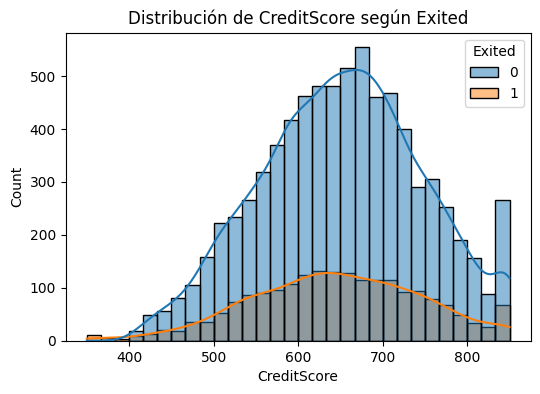

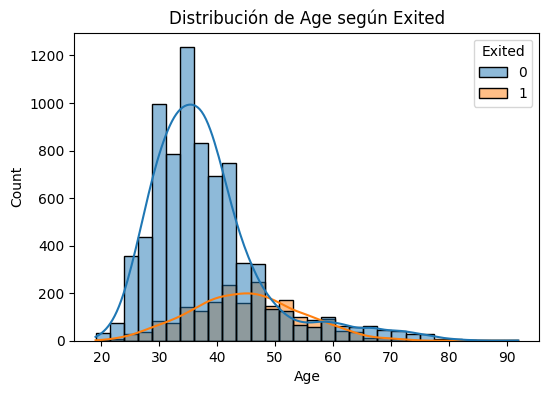

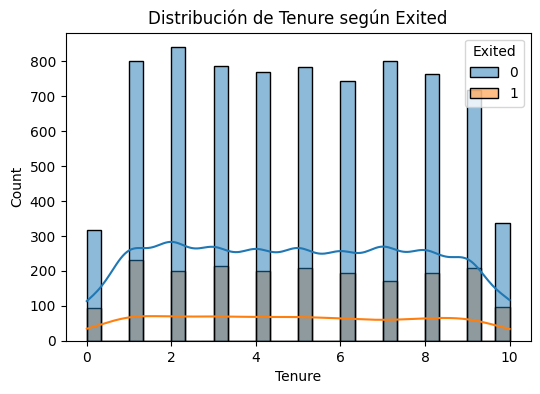

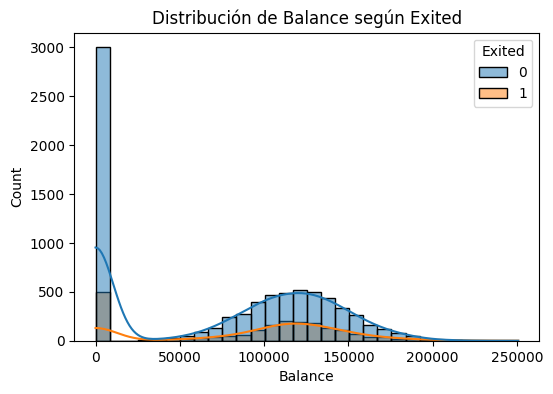

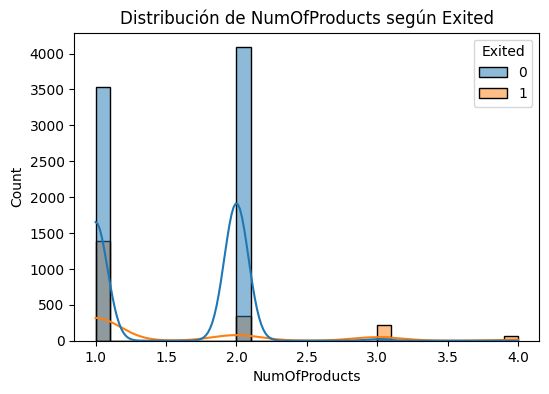

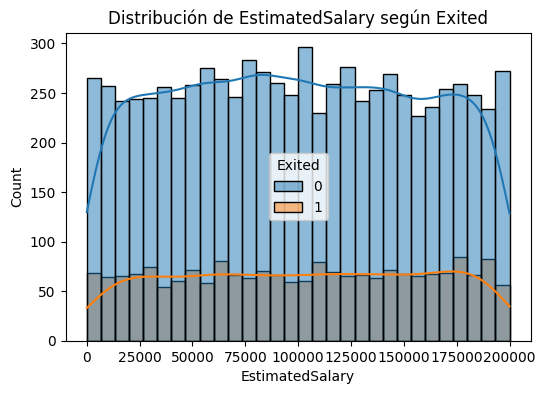

In [16]:
for col in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df_clean, x=col, hue='Exited', kde=True, bins=30)
    plt.title(f"Distribución de {col} según Exited")
    plt.show()

In [17]:
pd.crosstab(df_clean['Gender'], df_clean['Exited'], normalize='index') * 100

Exited,0,1
Gender,,
Female,74.466636,25.533364
Male,83.146707,16.853293


In [18]:
for col in categorical_features:
    print(f"\nCrosstab for {col} vs Exited:")
    print(pd.crosstab(df_clean[col], df_clean['Exited'], normalize='index') * 100)


Crosstab for Geography vs Exited:
Exited             0          1
Geography                      
France     83.477544  16.522456
Germany    66.966844  33.033156
Spain      83.010934  16.989066

Crosstab for Gender vs Exited:
Exited          0          1
Gender                      
Female  74.466636  25.533364
Male    83.146707  16.853293

Crosstab for HasCrCard vs Exited:
Exited             0          1
HasCrCard                      
0          78.832630  21.167370
1          79.344166  20.655834

Crosstab for IsActiveMember vs Exited:
Exited                  0          1
IsActiveMember                      
0               72.552783  27.447217
1               85.439230  14.560770


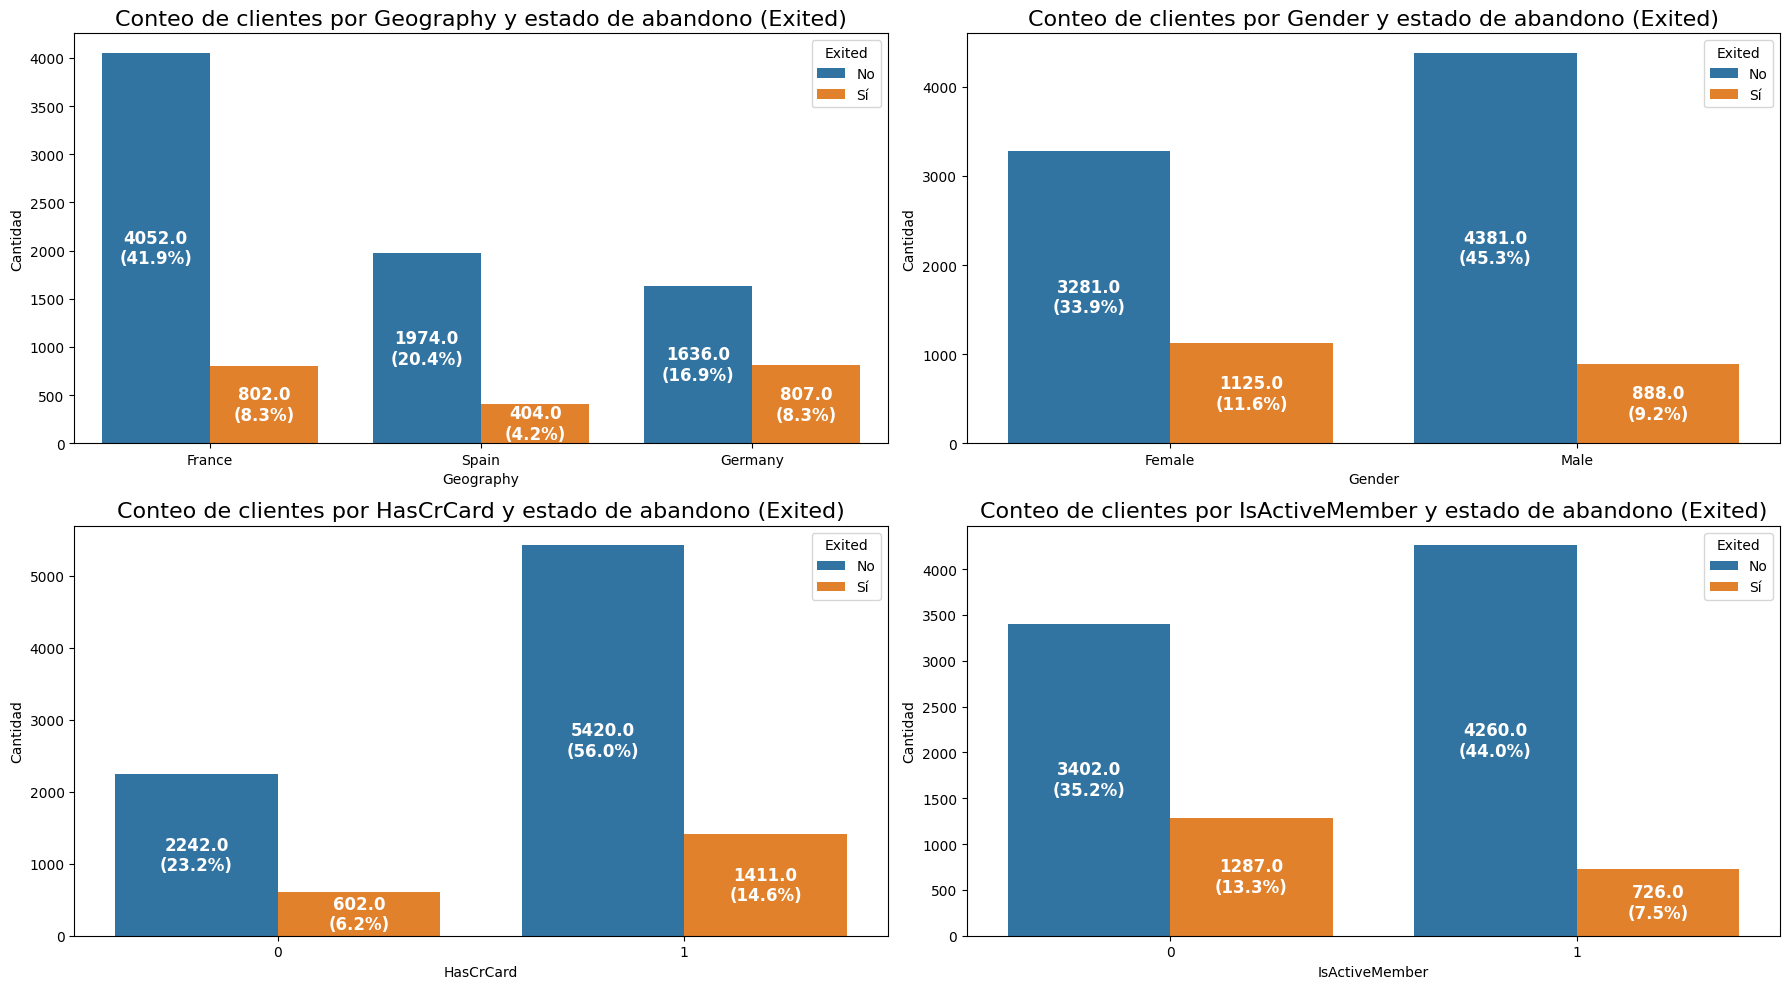

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 10))
total = len(df_clean)

for i, col in enumerate(categorical_features):
    ax = plt.subplot(2, 2, i + 1)
    chart = sns.countplot(data=df_clean, x=col, hue='Exited', ax=ax)

    for p in chart.patches:
        height = p.get_height()
        # Evita anotaciones en barras vacías
        if height == 0:
            continue

        percent = (height / total) * 100
        label = f'{height}\n({percent:.1f}%)'

        chart.annotate(
            label,
            (p.get_x() + p.get_width() / 2., height / 2),  # Posición centrada en la barra
            ha='center',
            va='center',
            fontsize=12,
            color='white',        # Blanco para mejor visibilidad dentro de la barra
            fontweight='bold'
        )

    ax.set_title(f'Conteo de clientes por {col} y estado de abandono (Exited)', fontsize=16)
    ax.set_xlabel(col)
    ax.set_ylabel('Cantidad')
    ax.legend(title='Exited', labels=['No', 'Sí'])

plt.tight_layout()
plt.show()


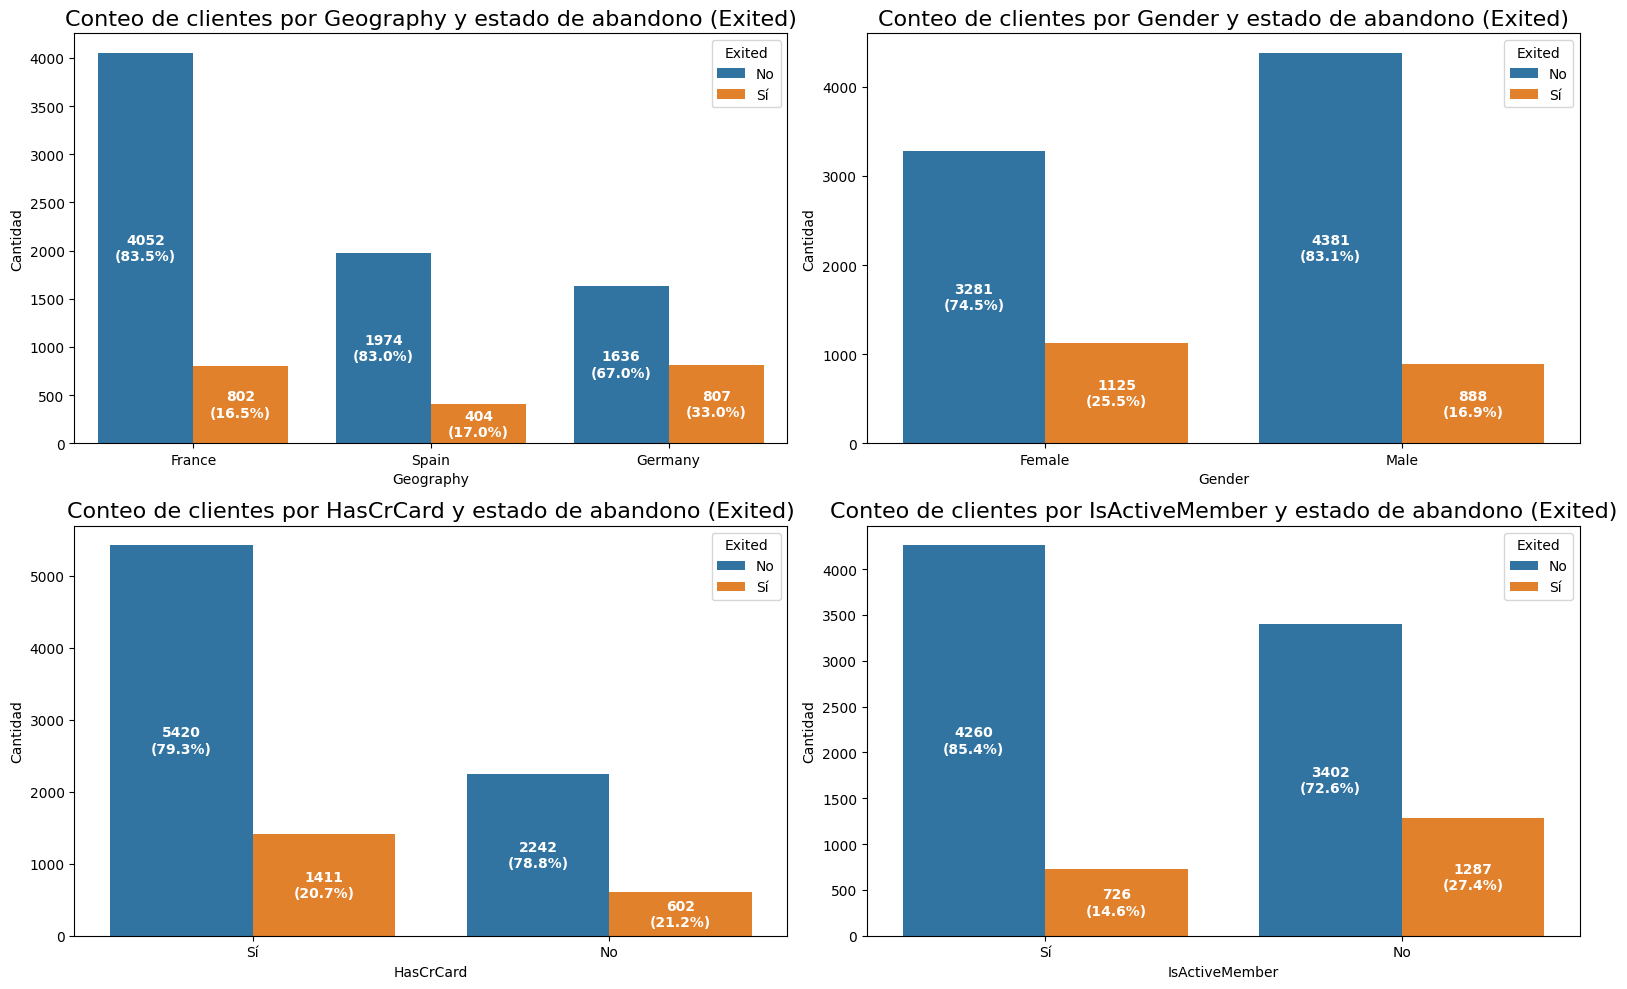

In [20]:
df_clean_cruzado = df_clean.copy()
df_clean_cruzado['HasCrCard'] = df_clean_cruzado['HasCrCard'].map({0: 'No', 1: 'Sí'})
df_clean_cruzado['IsActiveMember'] = df_clean_cruzado['IsActiveMember'].map({0: 'No', 1: 'Sí'})

plt.figure(figsize=(16, 10))

for i, col in enumerate(categorical_features):
    ax = plt.subplot(2, 2, i + 1)
    chart = sns.countplot(data=df_clean_cruzado, x=col, hue='Exited', ax=ax)

    # Total por categoría (ej. total hombres, total mujeres, etc.)
    totals = df_clean_cruzado[col].value_counts()

    for p in chart.patches:
        height = p.get_height()
        if height == 0:
            continue

        # Obtener categoría (x) y clase (0 o 1)
        cat = p.get_x() + p.get_width() / 2.
        cat_label = p.get_x()
        x_labels = [t.get_text() for t in chart.get_xticklabels()]
        idx = int(round(p.get_x() + p.get_width() / 2.))
        try:
            group = x_labels[idx]
        except:
            continue

        total_group = df_clean_cruzado[df_clean_cruzado[col] == group].shape[0]
        percent = (height / total_group) * 100
        label = f'{int(height)}\n({percent:.1f}%)'

        ax.text(p.get_x() + p.get_width()/2., height * 0.5, label,
                ha='center', va='center', color='white', fontweight='bold')

    ax.set_title(f'Conteo de clientes por {col} y estado de abandono (Exited)', fontsize=16)
    ax.set_xlabel(col)
    ax.set_ylabel('Cantidad')
    ax.legend(title='Exited', labels=['No', 'Sí'])

plt.tight_layout()
plt.show()


Correlación para variables numéricas

Usamos Pearson (es equivalente a punto-biserial cuando la variable dependiente es binaria).


C:\Users\horo\AppData\Local\Temp\ipykernel_1380\2719750475.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette="coolwarm")


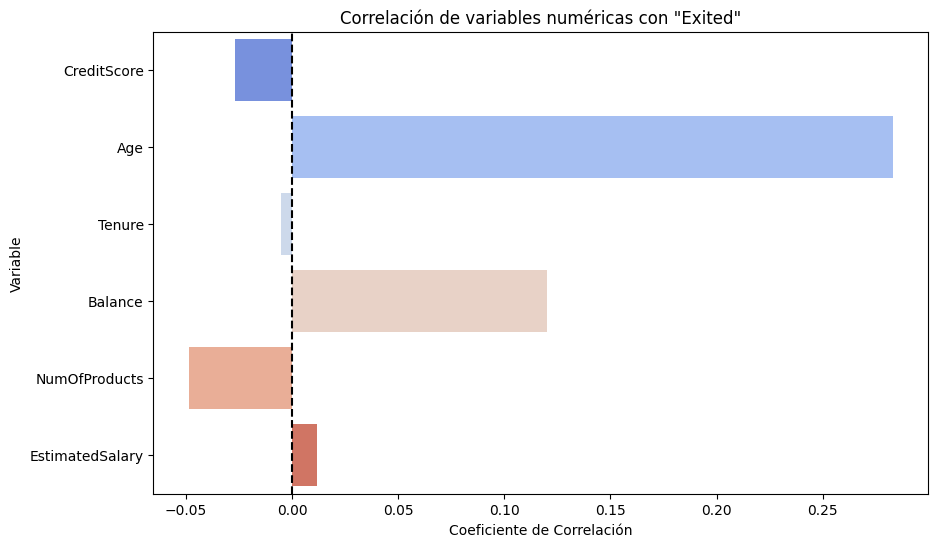

In [21]:
# Asegúrate de tener pandas y seaborn importados
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Selecciona las columnas numéricas más la variable objetivo
#numerical_features = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]
numerical_df = df_clean[numerical_features + ['Exited']]

# Calcula la matriz de correlación (Pearson por defecto)
corr_matrix = numerical_df.corr()

# Extrae solo la fila de la variable objetivo 'Exited'
corr_with_target = corr_matrix['Exited'].drop('Exited')  # Excluye a sí misma

# Visualiza en forma de barra
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette="coolwarm")
plt.title('Correlación de variables numéricas con "Exited"')
plt.xlabel('Coeficiente de Correlación')
plt.ylabel('Variable')
plt.axvline(0, color='black', linestyle='--')
plt.show()


¿Qué es Cramér’s V?

Es una métrica que va de 0 (sin asociación) a 1 (asociación perfecta). Funciona con tablas de contingencia.

In [22]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Función para calcular Cramér’s V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r) - 1)))

# Lista de variables categóricas
#categorical_features = ["Geography", "Gender", "HasCrCard", "IsActiveMember"]

# Calcular Cramér’s V para cada variable categórica respecto a 'Exited'
for col in categorical_features:
    cramer_v = cramers_v(df_clean[col], df_clean['Exited'])
    print(f'Cramér’s V entre {col} y Exited: {cramer_v:.4f}')


Cramér’s V entre Geography y Exited: 0.1751
Cramér’s V entre Gender y Exited: 0.1062
Cramér’s V entre HasCrCard y Exited: 0.0055
Cramér’s V entre IsActiveMember y Exited: 0.1584


In [23]:
df_customer_filtered = df_clean.copy()

In [24]:
# 1. Codificacion de categorical_features
categorical_features = ["Geography", "Gender", "HasCrCard", "IsActiveMember"]

# Codificación one-hot para "Geografía" y "Género"
# drop_first=True es para evitar la trampa de la variable ficticia
df_customer_encoded = pd.get_dummies(df_customer_filtered, columns=["Geography", "Gender"], drop_first=True)

# ¿Por qué solo se codifican dos características? Porque solo "Geografía" y "Género" tienen objeto como tipo de datos.

In [25]:
# 2. Utilizar StandardScaler para estandarizar los valores dentro de las características numéricas numerical_features

scaler = StandardScaler()
df_customer_encoded[numerical_features] = scaler.fit_transform(df_customer_encoded[numerical_features])

C:\Users\horo\AppData\Local\Temp\ipykernel_1380\3628718792.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette="coolwarm")


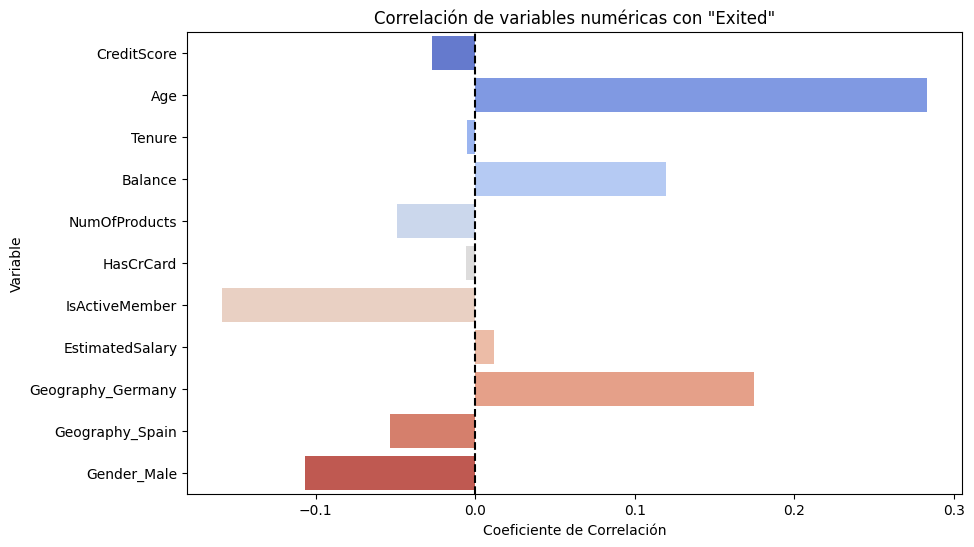

In [26]:
# Selecciona las columnas numéricas más la variable objetivo
#numerical_features = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]
numerical_df = df_customer_encoded

# Calcula la matriz de correlación (Pearson por defecto)
corr_matrix = numerical_df.corr()

# Extrae solo la fila de la variable objetivo 'Exited'
corr_with_target = corr_matrix['Exited'].drop('Exited')  # Excluye a sí misma

# Visualiza en forma de barra
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette="coolwarm")
plt.title('Correlación de variables numéricas con "Exited"')
plt.xlabel('Coeficiente de Correlación')
plt.ylabel('Variable')
plt.axvline(0, color='black', linestyle='--')
plt.show()

In [27]:
pd.set_option('display.max_rows', 20)  # Muestra todas las filas
print(corr_with_target)

CreditScore         -0.026837
Age                  0.283213
Tenure              -0.005212
Balance              0.119874
NumOfProducts       -0.048778
HasCrCard           -0.005741
IsActiveMember      -0.158656
EstimatedSalary      0.011652
Geography_Germany    0.175069
Geography_Spain     -0.053682
Gender_Male         -0.106492
Name: Exited, dtype: float64


CreditScore          0.145592
Age                  0.238455
Tenure               0.081052
Balance              0.142652
NumOfProducts        0.126669
HasCrCard            0.019131
IsActiveMember       0.041939
EstimatedSalary      0.145264
Geography_Germany    0.026895
Geography_Spain      0.014080
Gender_Male          0.018271
dtype: float64


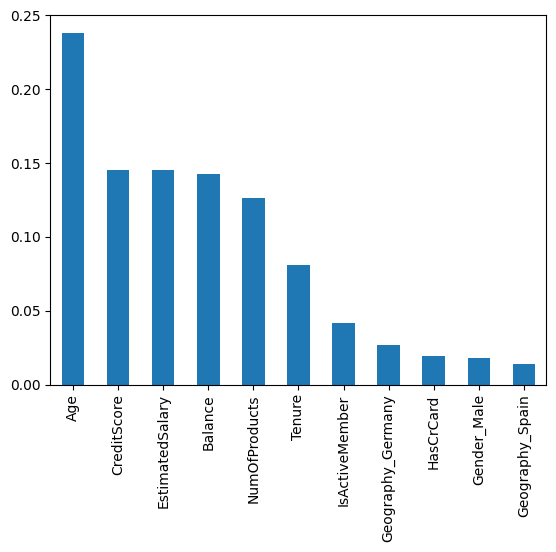

In [28]:
# Variable dependiente
y = df_customer_encoded["Exited"]

# Variables independientes (el resto de columnas menos 'Exited')
X = df_customer_encoded.drop(columns=["Exited"])

from sklearn.model_selection import train_test_split

# División 80% entrenamiento y 20% prueba (puedes ajustar si quieres)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar')
print(importances)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Crear el modelo base
model = LogisticRegression(solver='liblinear')

# Crear RFE con 5 características seleccionadas (ajusta este número)
rfe = RFE(estimator=model, n_features_to_select=11)

# Ajustar RFE al conjunto de entrenamiento
rfe.fit(X_train, y_train)

# Mostrar las columnas seleccionadas
selected_features = X_train.columns[rfe.support_]
print("Características seleccionadas por RFE:")
print(selected_features)
print(rfe.support_)

Características seleccionadas por RFE:
Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')
[ True  True  True  True  True  True  True  True  True  True  True]


In [30]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
selector = RFE(estimator=xgb_model, n_features_to_select=5, step=1)
selector = selector.fit(X_train, y_train)
selected_features = X.columns[selector.support_]
print("Características seleccionadas por RFE:")
print(selected_features)

feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': selector.ranking_,
    'Selected': selector.support_
}).sort_values(by='Ranking')

print(feature_ranking)

c:\Users\horo\.virtualenvs\ETL-LilrN0x0\lib\site-packages\xgboost\training.py:183: UserWarning: [17:16:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\horo\.virtualenvs\ETL-LilrN0x0\lib\site-packages\xgboost\training.py:183: UserWarning: [17:16:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\horo\.virtualenvs\ETL-LilrN0x0\lib\site-packages\xgboost\training.py:183: UserWarning: [17:16:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\horo\.virtualenvs\ETL-LilrN0x0\lib\site-packages\xgboost\training.py:183: UserWarning: [17:16:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Paramet

Características seleccionadas por RFE:
Index(['Age', 'Balance', 'NumOfProducts', 'IsActiveMember',
       'Geography_Germany'],
      dtype='object')
              Feature  Ranking  Selected
1                 Age        1      True
3             Balance        1      True
6      IsActiveMember        1      True
4       NumOfProducts        1      True
8   Geography_Germany        1      True
9     Geography_Spain        2     False
10        Gender_Male        3     False
5           HasCrCard        4     False
0         CreditScore        5     False
7     EstimatedSalary        6     False
2              Tenure        7     False


c:\Users\horo\.virtualenvs\ETL-LilrN0x0\lib\site-packages\xgboost\training.py:183: UserWarning: [17:16:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Entrenamiento:
Exited
0    6130
1    1610
Name: count, dtype: int64

Test:
Exited
0    1532
1     403
Name: count, dtype: int64
Entrenamiento: (7740, 11), (7740,)
Test: (1935, 11), (1935,)


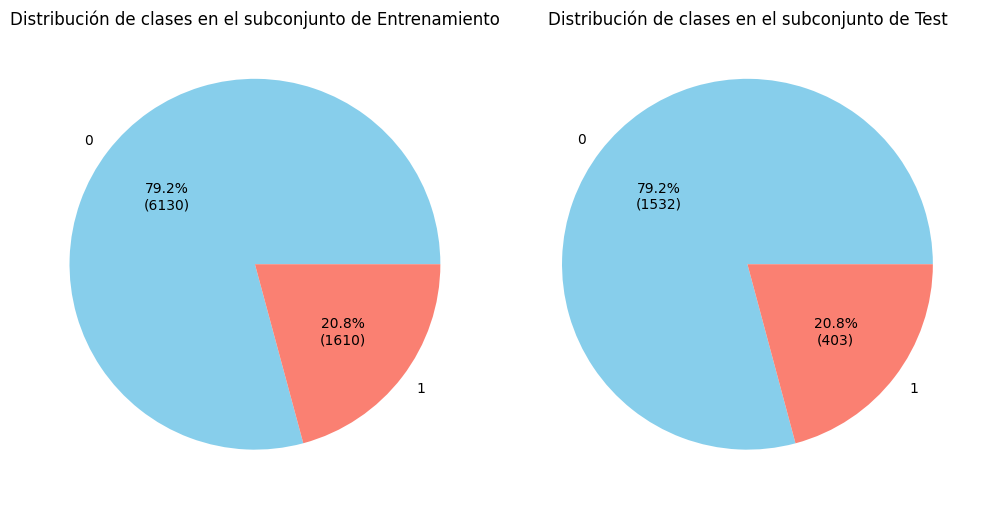

In [31]:
# Contar valores
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

# Mostrar conteo
print("Entrenamiento:")
print(train_counts)
print("\nTest:")
print(test_counts)

# Verificamos el tamaño de los conjuntos
print(f"Entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

# Función para mostrar porcentaje y total
def make_autopct(counts):
    def autopct(pct):
        total = sum(counts)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return autopct

# Gráficos de pastel
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Pie chart para entrenamiento
axes[0].pie(train_counts, labels=train_counts.index,
            autopct=make_autopct(train_counts),
            colors=['skyblue', 'salmon'])
axes[0].set_title('Distribución de clases en el subconjunto de Entrenamiento')

# Pie chart para test
axes[1].pie(test_counts, labels=test_counts.index,
            autopct=make_autopct(test_counts),
            colors=['skyblue', 'salmon'])
axes[1].set_title('Distribución de clases en el subconjunto de Test')

plt.tight_layout()
plt.show()

In [32]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,-0.323456,0.247800,-1.018177,-1.227340,-0.909104,1,1,0.024542,False,False,False
1,-0.437077,0.149744,-1.365332,0.116759,-0.909104,0,1,0.219045,False,True,False
2,-1.531969,0.247800,1.064752,1.333278,2.518636,1,0,0.243180,False,False,False
3,0.502877,-0.046368,-1.365332,-1.227340,0.804766,0,0,-0.106165,False,False,False
5,-0.054898,0.443912,1.064752,0.597060,0.804766,1,0,0.865680,False,True,True


Entrenamiento y comparación de modelos supervisados (con GridSearchCV)

In [33]:
# Modelos sin pesos de clase
models_sin_peso_clase = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),  # No necesita random_state ya que no tiene aleatoriedad
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "solver": ["lbfgs", "liblinear"],
            "penalty": ["l2"]
        }
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "criterion": ["gini", "entropy"], 
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ["sqrt", "log2"]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.8, 1],
            "colsample_bytree": [0.8, 1],
            "gamma": [0, 0.1, 0.3]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "num_leaves": [15, 31, 63],
            "subsample": [0.8, 1],
            "colsample_bytree": [0.8, 1],
            "reg_alpha": [0, 0.1, 1],
            "reg_lambda": [0, 0.1, 1]
        }
    }
}

In [34]:
# Modelos con pesos de clase
models_sin_balanceo = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, class_weight='balanced'),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "solver": ["lbfgs", "liblinear"],
            "penalty": ["l2"]
        }
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42, class_weight='balanced'),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        "params": {
            "criterion": ["gini", "entropy"], 
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ["sqrt", "log2"]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=3.8),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.8, 1],
            "colsample_bytree": [0.8, 1],
            "gamma": [0, 0.1, 0.3]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, class_weight='balanced'),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "num_leaves": [15, 31, 63],
            "subsample": [0.8, 1],
            "colsample_bytree": [0.8, 1],
            "reg_alpha": [0, 0.1, 1],
            "reg_lambda": [0, 0.1, 1]
        }
    }
}
# scale_pos_weight=3.8, es la division entre numero de negativos / numero de positivos. 1532/403 = 3.8

In [35]:
# Lista para almacenar resultados
resulado_sin_balanceo = []
best_models_sin_balanceo = {}  # Diccionario para guardar los modelos ya entrenados
reporte_sin_balanceo = []
reporte_umbral_sin_balanceo = []

limite_umbral = 0.4

In [36]:
def entrenamiento_modelo(modelo_hiperparametros, scoring, umbral, resulado_abandono, reporte, reporte_umbral, X_train, y_train, X_test, y_test):
    for name, mp in modelo_hiperparametros.items():
        print(f"\n Entrenando modelo: {name}")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        clf = GridSearchCV(mp["model"], mp["params"], cv=cv, scoring = scoring, n_jobs=-1) #n_jobs=-1 para usar todos los núcleos disponibles
        clf.fit(X_train, y_train)

        best_model = clf.best_estimator_
        best_models_sin_balanceo[name] = best_model  # Guardar el mejor modelo aquí
    
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        # Paso 2: aplicar umbral personalizado (ej. 0.4)
        y_pred_limite = (y_prob >= umbral).astype(int)

        report = classification_report(y_test, y_pred, output_dict=True)
        report["modelo"] = name
        reporte.append(report)
        report_umbral = classification_report(y_test, y_pred_limite, output_dict=True)
        report_umbral["modelo"] = name
        reporte_umbral.append(report_umbral)

        

        # Métricas adicionales
        auc_roc = roc_auc_score(y_test, y_prob)
        auc_pr = average_precision_score(y_test, y_prob)

        resulado_abandono.append({
            "Modelo": name,
            "Precisión": round(report["1"]["precision"], 2),
            "Recall": round(report["1"]["recall"], 2),
            "F1-Score": round(report["1"]["f1-score"], 2),
            "AUC-ROC": round(auc_roc, 2),
            "AUC-PR": round(auc_pr, 2),
            "Mejores Hiperparámetros": clf.best_params_
        })

In [37]:
entrenamiento_modelo(models_sin_balanceo, 'f1', limite_umbral, resulado_sin_balanceo, reporte_sin_balanceo, reporte_umbral_sin_balanceo, 
                    X_train, y_train, X_test, y_test)


 Entrenando modelo: Logistic Regression

 Entrenando modelo: SVM

 Entrenando modelo: Decision Tree

 Entrenando modelo: Random Forest

 Entrenando modelo: XGBoost


c:\Users\horo\.virtualenvs\ETL-LilrN0x0\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\horo\.virtualenvs\ETL-LilrN0x0\lib\site-packages\xgboost\training.py:183: UserWarning: [17:21:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Entrenando modelo: LightGBM
[LightGBM] [Info] Number of positive: 1610, number of negative: 6130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7740, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [46]:
resulado_sin_balanceo 
#best_models_sin_balanceo 
#reporte_sin_balanceo 
#reporte_umbral_sin_balanceo 


[{'Modelo': 'Logistic Regression',
  'Precisión': 0.39,
  'Recall': 0.7,
  'F1-Score': 0.5,
  'AUC-ROC': np.float64(0.77),
  'AUC-PR': np.float64(0.44),
  'Mejores Hiperparámetros': {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}},
 {'Modelo': 'SVM',
  'Precisión': 0.52,
  'Recall': 0.76,
  'F1-Score': 0.62,
  'AUC-ROC': np.float64(0.86),
  'AUC-PR': np.float64(0.68),
  'Mejores Hiperparámetros': {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}},
 {'Modelo': 'Decision Tree',
  'Precisión': 0.46,
  'Recall': 0.67,
  'F1-Score': 0.55,
  'AUC-ROC': np.float64(0.78),
  'AUC-PR': np.float64(0.58),
  'Mejores Hiperparámetros': {'criterion': 'entropy',
   'max_depth': 10,
   'min_samples_leaf': 2,
   'min_samples_split': 10}},
 {'Modelo': 'Random Forest',
  'Precisión': 0.6,
  'Recall': 0.69,
  'F1-Score': 0.64,
  'AUC-ROC': np.float64(0.87),
  'AUC-PR': np.float64(0.69),
  'Mejores Hiperparámetros': {'max_depth': 10,
   'max_features': 'sqrt',
   'min_samples_leaf': 1,
   'min_samples_split': 5,


In [39]:
# Extraer Modelo, AUC-ROC y AUC-PR
comparacion_auc = pd.DataFrame([
    {
        "Modelo": r["Modelo"],
        "AUC-ROC": float(r["AUC-ROC"]),
        "AUC-PR": float(r["AUC-PR"])
    } for r in resulado_sin_balanceo
])

# Mostrar DataFrame ordenado por AUC-ROC descendente
comparacion_auc.sort_values(by="AUC-ROC", ascending=False)

,Modelo,AUC-ROC,AUC-PR
4,XGBoost,0.87,0.72
3,Random Forest,0.87,0.69
5,LightGBM,0.86,0.71
1,SVM,0.86,0.68
2,Decision Tree,0.78,0.58
0,Logistic Regression,0.77,0.44


In [40]:
# Función para extraer los datos comparables
def extraer_metricas(reporte, limite):
    data = []
    for report in reporte:
        modelo = report['modelo']
        accuracy = report['accuracy']
        precision_1 = report['1']['precision']
        recall_1 = report['1']['recall']
        f1_1 = report['1']['f1-score']
        support_1 = report['1']['support']
        precision_0 = report['0']['precision']
        recall_0 = report['0']['recall']
        f1_0 = report['0']['f1-score']
        support_0 = report['0']['support']
        data.append({
            "Modelo": modelo,
            "Umbral": limite,
            "Accuracy": round(accuracy, 3),
            "Precision (1)": round(precision_1, 3),
            "Recall (1)": round(recall_1, 3),
            "F1-score (1)": round(f1_1, 3),
            "support (1)": int(support_1),
            "Precision (0)": round(precision_0, 3),
            "Recall (0)": round(recall_0, 3),
            "F1-score (0)": round(f1_0, 3),
            "support (0)": int(support_0)
        })
    return data

In [41]:
pd.set_option('display.max_rows', 20)  # Muestra todas las filas
# Extraer métricas de ambas listas
data_reporte = extraer_metricas(reporte_sin_balanceo, "0.5")
data_reporte_umbral = extraer_metricas(reporte_umbral_sin_balanceo, limite_umbral)

# Crear DataFrame combinando ambas
df_comparacion = pd.DataFrame(data_reporte + data_reporte_umbral)

# Mostrar ordenado por modelo
df_comparacion = df_comparacion.sort_values(by=["Modelo", "Umbral"]).reset_index(drop=True)
df_comparacion.sort_values(by="Modelo", ascending=False)

,Modelo,Umbral,Accuracy,Precision (1),Recall (1),F1-score (1),support (1),Precision (0),Recall (0),F1-score (0),support (0)
10,XGBoost,0.4,0.739,0.433,0.831,0.570,403,0.941,0.714,0.812,1532
11,XGBoost,0.5,0.808,0.528,0.747,0.619,403,0.925,0.824,0.872,1532
8,SVM,0.4,0.838,0.610,0.620,0.615,403,0.900,0.896,0.898,1532
9,SVM,0.5,0.802,0.516,0.764,0.616,403,0.929,0.811,0.866,1532
6,Random Forest,0.4,0.793,0.502,0.779,0.611,403,0.932,0.797,0.859,1532
7,Random Forest,0.5,0.838,0.597,0.690,0.640,403,0.915,0.877,0.896,1532
4,Logistic Regression,0.4,0.591,0.317,0.839,0.460,403,0.925,0.525,0.670,1532
5,Logistic Regression,0.5,0.714,0.394,0.700,0.504,403,0.901,0.717,0.799,1532
2,LightGBM,0.4,0.786,0.491,0.777,0.601,403,0.931,0.788,0.853,1532
3,LightGBM,0.5,0.816,0.544,0.702,0.613,403,0.915,0.845,0.879,1532


In [42]:
best_models_sin_balanceo

{'Logistic Regression': LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000),
 'SVM': SVC(C=1, class_weight='balanced', probability=True, random_state=42),
 'Decision Tree': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                        max_depth=10, min_samples_leaf=2, min_samples_split=10,
                        random_state=42),
 'Random Forest': RandomForestClassifier(class_weight='balanced', max_depth=10,
                        min_samples_split=5, n_estimators=200, random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=0.1,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0

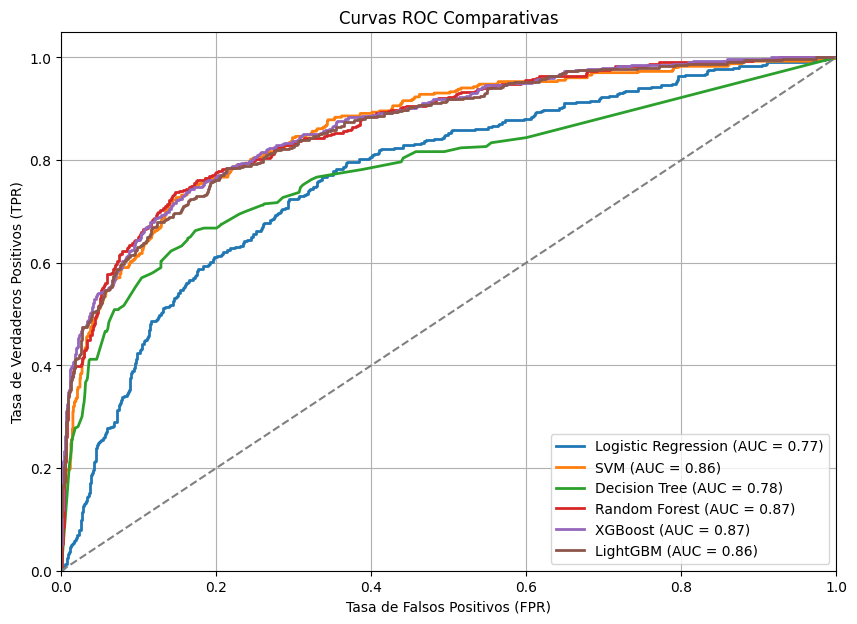

In [43]:
plt.figure(figsize=(10, 7))

# Trazar curvas ROC
for name, model in best_models_sin_balanceo.items():
    y_score = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Curva base
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Comparativas')
plt.legend(loc="lower right")
plt.grid()
plt.show()

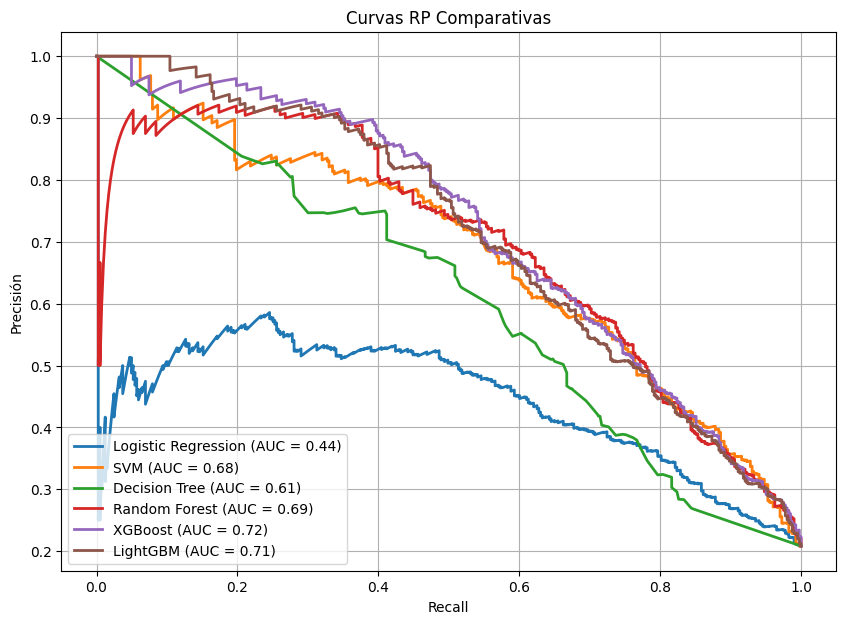

In [44]:
plt.figure(figsize=(10, 7))

# Trazar curvas PR
for name, model in best_models_sin_balanceo.items():
    y_score = model.predict_proba(X_test)[:, 1]
    
    # PR
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    pr_auc = auc(recall, precision)
    
    plt.plot(recall, precision , lw=2, label=f'{name} (AUC = {pr_auc:.2f})')

# Curva base
#plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curvas RP Comparativas')
plt.legend(loc="lower left")
plt.grid()
plt.show()


Matriz de Confusión para Logistic Regression:
[[1099  433]
 [ 121  282]]

Matriz de Confusión para SVM:
[[1243  289]
 [  95  308]]

Matriz de Confusión para Decision Tree:
[[1218  314]
 [ 132  271]]

Matriz de Confusión para Random Forest:
[[1344  188]
 [ 125  278]]

Matriz de Confusión para XGBoost:
[[1263  269]
 [ 102  301]]

Matriz de Confusión para LightGBM:
[[1295  237]
 [ 120  283]]


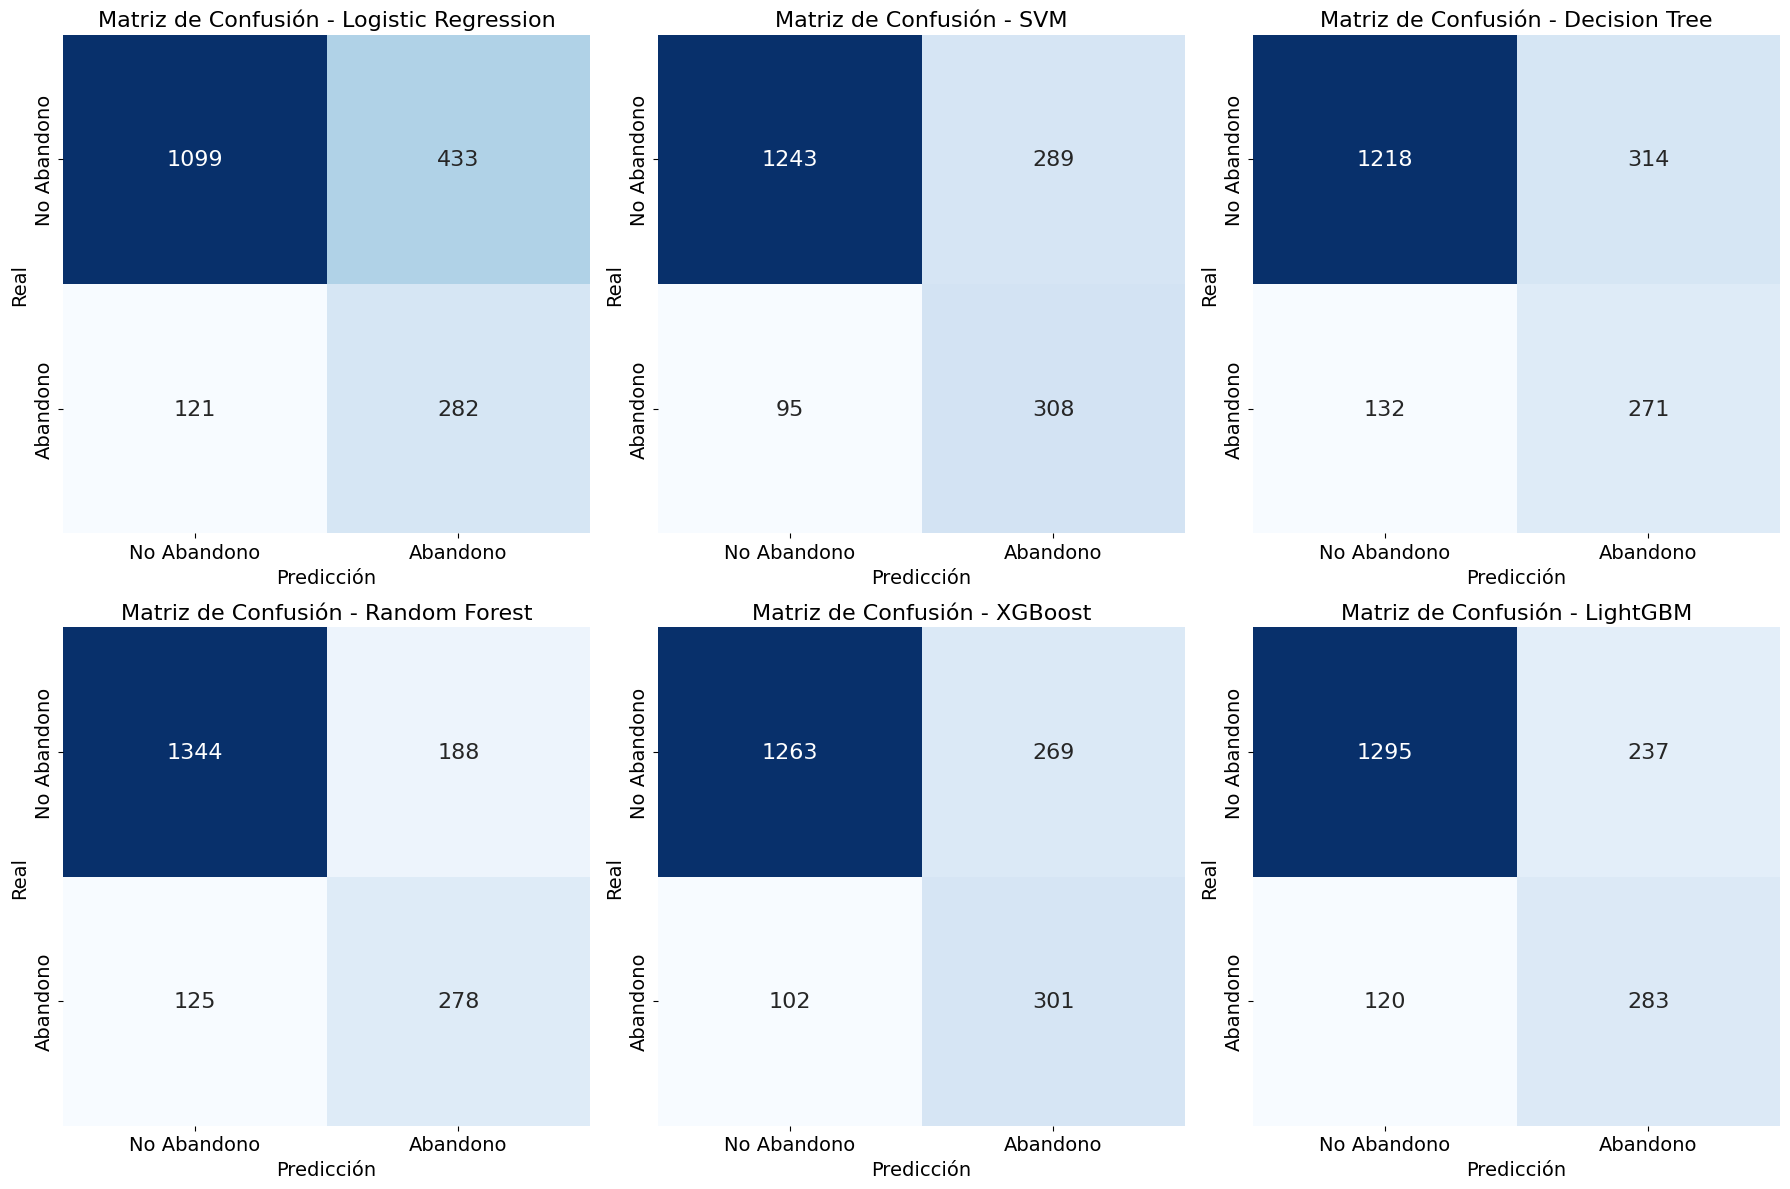

In [45]:
####  Matriz de Confusión por Modelo
# El orden debe corresponder a los valores numéricos de las clases.
# Si 0 es 'No Abandono' y 1 es 'Abandono', la lista debe ser:
class_labels = ['No Abandono', 'Abandono']

# Crear una figura con una cuadrícula de 2 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) # figsize ajusta el tamaño total del gráfico
# Aplanar el array de axes para poder iterar sobre él fácilmente
axes = axes.flatten()

# Iterar sobre los modelos y sus índices para colocarlos en la cuadrícula
for i, (name, model) in enumerate(best_models_sin_balanceo.items()):
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nMatriz de Confusión para {name}:\n{cm}")
    # Seleccionar el subplot actual para dibujar
    ax = axes[i]

    # Dibujar el mapa de calor de la matriz de confusión
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                xticklabels=class_labels, yticklabels=class_labels,
                # Agrega el siguiente parámetro para controlar el tamaño de la fuente de los números
                annot_kws={"size": 16})
    
    ax.set_title(f'Matriz de Confusión - {name}', fontsize = 16)
    ax.set_xlabel('Predicción', fontsize = 14)
    ax.set_ylabel('Real', fontsize = 14)

    # Agrega las siguientes líneas para controlar el tamaño de la fuente de las etiquetas de los ticks (No Abandono, Abandono)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

plt.show()